In [53]:
import numpy as np
import pandas as pd
import os
import glob

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

from sklearn import tree
import subprocess
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Spam Detection Filter

Let us illustrate a few concepts from before on a case study -- building a spam detection filter. The data for this notebook is from https://medium.com/analytics-vidhya/building-a-spam-filter-from-scratch-using-machine-learning-fc58b178ea56.

## Read Data

The emails are currently organized in four directories (see data/email): nonspam-train, nonspam-test, spam-train, and spam-test, with one file per email. The data looks preprocessed, i.e. lower-cased, etc.

In [3]:
%ls data/email | head

nonspam-test/
nonspam-train/
spam-test/
spam-train/


Legit email example:

In [4]:
%cat data/email/nonspam-train/3-380msg4.txt | head

posting hi m work phonetics project modern irish m hard source anyone recommend book article english specifically interest palatal slender consonant work helpful too thank laurel sutton sutton garnet berkeley edu 

Spam email:

In [5]:
%cat data/email/spam-train/spmsga1.txt | head

great parttime summer job display box credit application need place small owneroperate store area here introduce yourself store owner manager our effective script tell little display box save customer hundred dollar draw card business every app send spot counter place box nothing need need name address company send commission check compensaation every box place become representative earn commission each application store course much profitable plan pay month small effort call code hours receive detail removed our mailing list type b hotmail com area remove subject area e mail send 

We arrange the data into two Pandas dataframes: df_train and df_test:

In [6]:
base_dir = "./data/email"
train_spam, train_legit = "./data/email/spam-train/*", "./data/email/nonspam-train/*"
test_spam,test_legit = "./data/email/spam-test/*", "./data/email/nonspam-test/*"
file_paths = glob.glob('./data/email/spam-train/*')
file_paths[:5]

['./data/email/spam-train/spmsga95.txt',
 './data/email/spam-train/spmsgc4.txt',
 './data/email/spam-train/spmsgc108.txt',
 './data/email/spam-train/spmsga32.txt',
 './data/email/spam-train/spmsgc50.txt']

In [7]:
def read_emails(dir_):
     return [' '.join(open(file_path, "r").readlines()).strip() for file_path in glob.glob(dir_)]

def read_df(spam_dir, legit_dir):
    # spam
    df_spam = pd.DataFrame({'email':read_emails(spam_dir)})
    df_spam['spam'] = 1
    # legit
    df_legit = pd.DataFrame({'email':read_emails(legit_dir)})
    df_legit['spam'] = 0
    return pd.concat([df_spam,df_legit])

df_train = read_df(train_spam, train_legit)
df_test = read_df(test_spam, test_legit)
df_train.shape, df_test.shape

((700, 2), (260, 2))

This is what the data look like:

In [8]:
df_train.head()

,email,spam
0,service update due significant rapid policy ch...,1
1,home base travel biz free cruise k st mo incom...,1
2,ask join kiddin list owner kiddin invite join ...,1
3,pardon intrusion want read follow pardon intru...,1
4,international driver s license need driver s l...,1


In [9]:
df_test.head()

,email,spam
0,thief proof car thief proof car peripheral con...,1
1,eureka hey check everythig site free s actuall...,1
2,hello university degree programs increase pers...,1
3,change life money excuses both dares nothing n...,1
4,hot free xxx software hetero http csend straig...,1


In [10]:
# May be save it for future use?
#df_train.to_csv('./data/email/train.csv')
#df_test.to_csv('./data/email/test.csv')

## TfidfVectorizer

We are going to use a bag-of-words model to translate each email into a feature vector. TfidfVectorizer (term-frequency * inverse document frequency) will do the translation. Another option is using CountVectorizer that does not consider the overall document frequency of each word.

See also the commented out parameters when creating tf:

In [24]:
tf = TfidfVectorizer(
    #ngram_range = (1,2) # how many words per each term?
    #,stop_words = 'english' # do we want to use the stop words?
    #,max_features = 10000 # what is the max vocabulary size?
    #,max_df = 1.0 # maximum document frequency
    #,min_df = 1.0 # minimum document frequency
)
X_train = tf.fit_transform(df_train['email'])
y_train = df_train['spam']
X_test = tf.transform(df_test['email'])
y_test = df_test['spam']

In [25]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((700, 19073), (700,), (260, 19073), (260,))

## Principal Component Analysis

The feature vector currently has X_train.shape[1] features that are not necessarily orthogonal to each other. To reduce the number of features, let us apply the Principal Component Analysis (PCA):

In [26]:
p = PCA() # use all defaults

p.fit(
    X_train.todense() # X_train is a sparse array, so we convert it to dense array first
) 

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

How many features (components) are needed to explain 95% of the variance?

In [27]:
n_comps = np.argmax(np.cumsum(p.explained_variance_) > 0.95)
n_comps

598

Re-run the PCA with that many components. You can re-do PCA with more or fewer components:

In [28]:
p = PCA(n_components = n_comps)
X_train_pca = p.fit_transform(X_train.todense())
X_test_pca = p.transform(X_test.todense())
X_train_pca.shape,X_test_pca.shape

((700, 598), (260, 598))

## Modeling
We try a few models on our data:
* Logistic Regression
* An artificial neural network

### Logistic Regression

In [29]:
lr = LogisticRegression(
    random_state = 1
    , solver = 'lbfgs'
)
lr.fit(X_train_pca, y_train)
y_pred = lr.predict(X_test_pca)

In [30]:
print(classification_report(y_test,y_pred, target_names = ['legit','spam']))

              precision    recall  f1-score   support

       legit       0.97      0.99      0.98       130
        spam       0.99      0.97      0.98       130

   micro avg       0.98      0.98      0.98       260
   macro avg       0.98      0.98      0.98       260
weighted avg       0.98      0.98      0.98       260



The model performance is really good. The lowest scores are the precision on the legit emails and recall on spam ones. It means that the logistic regression occasionally fails to filter out spam emails. The good news is that 99% of the legit emails are recognized as legit. 

### Artificial Neural Network

At this time, let us try an artificial neural network and see if we can improve the scores:

In [ ]:
nn = MLPClassifier(hidden_layer_sizes = [100,100,10]
                   ,learning_rate_init = 0.0002
                   ,max_iter = 1000
                   ,verbose = 1, random_state = 2)
nn.fit(X_train_pca, y_train)
y_pred = nn.predict(X_test_pca)

In [36]:
print(classification_report(y_test,y_pred, target_names = ['legit','spam']))

              precision    recall  f1-score   support

       legit       0.99      0.99      0.99       130
        spam       0.99      0.99      0.99       130

   micro avg       0.99      0.99      0.99       260
   macro avg       0.99      0.99      0.99       260
weighted avg       0.99      0.99      0.99       260



## Trying out the spam filter

Let us put all the steps into a pipeline:
* TfidFVectorizer to convert the text to word counts;
* Transform the sparse matrix to dense;
* Apply principal component analysis;
* Run artificial neural network to predict if the email is spam;

In [37]:
model = Pipeline([('tfidfvectorizer',tf)
                 ,('todense',FunctionTransformer(lambda x: x.todense(), accept_sparse=True, validate = False))
                 ,('pca',p)
                 ,('ann',nn)])

The method returns two numbers which can be thought of as 'probabilities' that the email is legit (1st) vs. spam (2nd)

In [38]:
model.predict_proba(['Hello'])

array([[ 0.02945142,  0.97054858]])

We can also call it at runtime and see its work:

In [39]:
interact(lambda x:print("Spam probability: %.2f%%"%(model.predict_proba([x])[0][1]*100.0))
         , x='Hi there!')

interactive(children=(Text(value='Hi there!', description='x'), Output()), _dom_classes=('widget-interact',))

<function __main__.<lambda>>

## Looking `inside` the model

Is there a way to look inside the model, i.e. see what words help it make the decisions? Let's try to do this with help of a decision tree.

### Decision tree

Let us use a decision tree of depth 3, which still works decently:

In [95]:
dt = DecisionTreeClassifier(max_depth = 3)
dt.fit(X_train_pca,y_train)
y_pred = dt.predict(X_test_pca)

print(classification_report(y_test,y_pred, target_names = ['legit','spam']))

              precision    recall  f1-score   support

       legit       0.96      0.95      0.96       130
        spam       0.95      0.96      0.96       130

   micro avg       0.96      0.96      0.96       260
   macro avg       0.96      0.96      0.96       260
weighted avg       0.96      0.96      0.96       260



This is what the tree looks like:

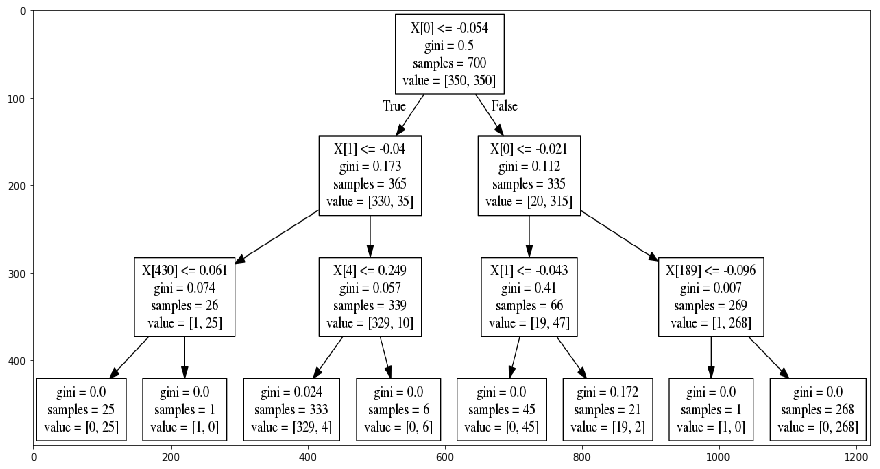

In [96]:
tree.export_graphviz(dt, out_file = 'tree.dot')
subprocess.call(['dot','-Tpng','tree.dot','-o','tree.png'])
img = mpimg.imread('tree.png')
plt.figure(figsize=(15,8))
imgplot = plt.imshow(img, aspect='auto')
plt.show()

The rightmost leaf represents the case with 268 spam emails and no (0) legit ones. One can reach it by making X[0] > -0.021 and X[189] > -0.096. We can simulate this case:

In [100]:
sim_X = np.zeros(n_comps)
sim_X[0] = 1
sim_X[189] = 1
tf_idf_sim_X = p.inverse_transform(sim_X)
tf_idf_sim_X.shape

(19073,)

TfidfVectorizer has vocabulary in a form of {'word':idx,...}. Let us swap the keys and values there:

In [101]:
inv_vocabulary = dict(zip(tf.vocabulary_.values(),tf.vocabulary_.keys()))

Now, find the highest features of tf_idf_sim_X (the terms with the highest scores):

In [102]:
[inv_vocabulary[idx] for idx in np.argsort(-tf_idf_sim_X)[:10]]

['report',
 'order',
 'email',
 'program',
 'address',
 'business',
 'mail',
 'money',
 'list',
 'our']

So, it turns out that the terms like 'report', 'order', 'email' are the heavy indicators of the spam. 

What about the legit email? Here are the requirements:

* X[0] <= -0.054
* X[1] > -0.04
* X[4] <= 0.249

In [103]:
sim_X = np.zeros(n_comps)
sim_X[0] = -1
sim_X[1] = 1
sim_X[4] = -1
tf_idf_sim_X = p.inverse_transform(sim_X)
tf_idf_sim_X.shape

(19073,)

What are the words pertaining to a legit email?

In [105]:
[inv_vocabulary[idx] for idx in np.argsort(-tf_idf_sim_X)[:10]]

['language',
 'linguistic',
 'university',
 'de',
 'english',
 'conference',
 'book',
 'abstract',
 'edu',
 'theory']

Now, try to construct the email with the words above and see what its spam probability looks like